# 📘 Theorie- und Einleitungsteil – SVHN Projektarbeit

## 1. Aufgabe (Task to solve)

In diesem Projekt soll ein Modell darauf trainiert werden, **Ziffern (0–9)** auf realen Straßenaufnahmen zu erkennen.
Es handelt sich um ein **multiklassiges Bildklassifikationsproblem**.
Das Modell soll jedem Eingabebild die wahrscheinlichste Klasse \(0,1,\dots,9\) zuordnen.

---

## 2. Datensatz (Data used)

Für das Projekt wird der **Street View House Numbers (SVHN)** Datensatz verwendet.

### 2.1 Datentyp
- Farbige **RGB-Bilder**
- Auflösung: **32 × 32 Pixel**
- Realweltaufnahmen von Hausnummern
- Jede Ziffer liegt als einzelnes Bild vor

### 2.2 Größe des Datensatzes
- **Training Set:** 73.257 Bilder
- **Test Set:** 26.032 Bilder
- **Additional Set:** 531.131 Bilder (optional)

### 2.3 Labels
- Labelbereich: **1–10**, wobei **10 die Ziffer 0** repräsentiert
- Labels werden vor Training entsprechend korrigiert

---

## 3. Modellarchitektur (Model architecture)

Es wird ein **Convolutional Neural Network (CNN)** verwendet, da CNNs besonders geeignet sind für Bilddaten aufgrund lokaler Mustererkennung.

Die geplante Architektur:

1. **Convolution Layer** (5×5, 3 → 10 Kanäle)
2. **Max-Pooling Layer** (2×2)
3. **ReLU-Aktivierung**
4. **Convolution Layer** (5×5, 10 → 20 Kanäle)
5. **Dropout2D**
6. **Max-Pooling Layer** (2×2)
7. **ReLU-Aktivierung**
8. **Flatten Layer**
9. **Fully Connected Layer** (auf 50 Neuronen)
10. **ReLU**
11. **Fully Connected Layer** (auf 10 Klassen)
12. **Log-Softmax-Ausgabe**

Dieses CNN extrahiert zuerst lokale Merkmale (Kanten, Formen), reduziert die räumlichen Dimensionen mittels Pooling und klassifiziert anschließend die resultierenden Feature Maps.

---

## 4. Basiseinstellungen für Training und Test (Basic training/testing setup)

### 4.1 Preprocessing
- Normalisierung der Pixelwerte auf Bereich \([0,1]\)
- Normalisierung jedes RGB-Kanals: Mittelwert 0.5, Standardabweichung 0.5

### 4.2 Hyperparameter
| Parameter | Wert |
|----------|------|
| Optimizer | SGD |
| Learning Rate | 0.01 |
| Momentum | 0.5 |
| Batch Size (Train) | 64 |
| Batch Size (Test) | 1000 |
| Epochen | 3 (Baseline) |
| Weight Initialization | Kaiming/He |

### 4.3 Loss Function
- **Negative Log Likelihood Loss (NLLLoss)**
- Wird mit **LogSoftmax** kombiniert

### 4.4 Trainingspipeline
1. Laden der Trainingsbatches
2. Forward Pass durch das CNN
3. Berechnung des NLL-Loss
4. Backpropagation
5. Update der Gewichte mit SGD
6. Wiederholung über mehrere Epochen

### 4.5 Evaluation
- Test-Loss
- Test-Accuracy
- Ausgabe der Modellvorhersagen auf Beispielbildern

---

## 5. Ziel des Projektes

- Aufbau eines funktionierenden CNNs für das SVHN-Dataset
- Durchführung **vier unterschiedlicher Experimente** (Hyperparameter- und Architekturvergleiche)
- Analyse und Visualisierung der Trainingsergebnisse
- Erkennen des Einflusses verschiedener Einstellungen wie:
  - Learning Rate
  - Optimizer
  - Netzwerkarchitektur
  - Batch Size
  - Weight Initialization

Ziel ist es, ein besseres Verständnis für das Verhalten neuronaler Netze und deren Hyperparameter in realen Bildklassifikationsproblemen zu entwickeln.


# Experiment

## wichtige Pakete einlesen

In [2]:
import torch                # PyTorch: das Hauptframework für Deep Learning (Tensors, Autograd, Modelle, Training)
import torchvision          # TorchVision: Bibliothek mit Standard-Datasets, Modellen und Bildtransformationen
import torch.nn as nn       # nn = Neural Network Module: für das Erstellen von Layern (z.B. Conv2d, Linear, ReLU)
import torch.nn.functional as F  # Funktionale API: für direkte Nutzung von Aktivierungsfunktionen, Losses, etc. (z.B. F.relu)
import torch.optim as optim       # Optimizer (z.B. SGD, Adam) für das Training von Modellen
import matplotlib.pyplot as plt   # Matplotlib: zum Plotten von Bildern, Trainingskurven oder Loss/Accuracy
import random                     # Python Standardbibliothek: für zufällige Zahlen, Shuffling, Seed-Kontrolle
import scipy.io# SciPy I/O: um .mat-Dateien (MATLAB-Format) zu laden, z.B. deine train/test Daten
from torch.utils.data import Dataset, DataLoader
                                  # Dataset: Basisklasse für eigene Datensätze
                                  # DataLoader: erleichtert Batch-Verarbeitung, Shuffling und Parallelisierung beim Training
import torchvision.transforms as transforms
                                  # Transformations für Bilder: z.B. Normalisierung, Resizing, RandomCrop, ToTensor



## SVHNDataset Klasse

In dieser Zelle wird eine **PyTorch Dataset-Klasse** für den SVHN-Datensatz definiert.

- **Zweck:** Ermöglicht es, `.mat`-Dateien mit Bildern und Labels einfach in PyTorch zu laden und in Batches zu verarbeiten.
- **Funktionen:**
  - `__init__`: Lädt die Daten aus der `.mat`-Datei und speichert optionale Transformationen.
  - `__len__`: Gibt die Anzahl der Bilder zurück (wichtig für DataLoader).
  - `__getitem__`: Liefert ein einzelnes Bild und Label als Tensor, normalisiert die Pixel und wendet Transformationen an.
- **Besonderheiten:**
  - Pixelwerte werden von [0,255] auf [0,1] normalisiert.
  - SVHN Label „10“ wird in `0` umgewandelt.
  - PyTorch erwartet die Kanal-Reihenfolge `(C,H,W)`, daher wird das Bild umgeformt.


In [4]:
print("Hallo Welt")
class SVHNDataset(Dataset):
    # Wir erben von torch.utils.data.Dataset, damit PyTorch den DataLoader nutzen kann

    def __init__(self, mat_file, transform=None):
        # Konstruktor: Lädt die .mat-Datei und initialisiert Variablen
        data = scipy.io.loadmat(mat_file)   # scipy.io.loadmat: lädt MATLAB-Dateien
        self.X = data['X']                  # X enthält die Bilder: shape (32, 32, 3, N)
        self.y = data['y'].flatten()        # y enthält Labels: shape (N,). flatten() macht aus Spaltenvektor 1D-Array
        self.transform = transform          # Transformationsobjekt für Bildvorverarbeitung (optional)

        # SVHN-Spezialfall: Label "10" bedeutet Ziffer "0"
        self.y[self.y == 10] = 0

    def __len__(self):
        # Gibt die Anzahl der Samples zurück, damit DataLoader weiß, wie viele es gibt
        return self.X.shape[3]              # N = Anzahl Bilder

    def __getitem__(self, idx):
        # Liefert ein einzelnes Sample (Bild + Label) für Index idx
        img = self.X[:,:,:,idx]             # Bild: (32,32,3)
        # torch.tensor: konvertiert numpy-array zu Tensor
        # permute(2,0,1): PyTorch erwartet Kanal zuerst (C,H,W) statt H,W,C
        # float()/255.0: normalisiert Pixelwerte von [0,255] auf [0,1]
        img = torch.tensor(img).permute(2,0,1).float()/255.0
        label = int(self.y[idx])            # Label als Integer

        if self.transform:
            img = self.transform(img)       # Falls Transform gesetzt, anwenden (z.B. RandomCrop, Normalize)

        return img, label                     # Rückgabe: Tensorbild + Label


In [6]:
transform = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

train_dataset = SVHNDataset('data/train_32x32.mat', transform=transform)
test_dataset  = SVHNDataset('data/test_32x32.mat',  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


oder über torchvision

In [27]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

# Train-Set
train_dataset = datasets.SVHN(
    root="data",
    split='train',      # 'train' = train_32x32.mat
    download=True,      # lädt automatisch herunter, wenn nicht vorhanden
    transform=transform
)

# Test-Set
test_dataset = datasets.SVHN(
    root="data",
    split='test',       # 'test' = test_32x32.mat
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


## Überblick über die Test- und Trainingsdaten
In dieser Zelle werden die Dateien im aktuellen Projektverzeichnis aufgelistet und die Größen der Trainings- und Testdaten angezeigt.

- `os.listdir()`: Listet alle Dateien und Ordner im aktuellen Verzeichnis auf.
- `os.path.getsize(path)`: Gibt die Größe einer Datei in Bytes zurück.
- Die Größe der `.mat`-Dateien wird in Megabyte (MB) umgerechnet, um die Dateigröße übersichtlich darzustellen.
- Ziel: Überprüfen, dass die Trainings- und Testdaten vorhanden sind und wie groß sie sind.

In [28]:
import os  # Zugriff auf Betriebssystemfunktionen (Dateien, Verzeichnisse)

# Liste alle Dateien und Ordner im aktuellen Verzeichnis auf
for f in os.listdir():
    print(f)  # Druckt jeden Dateinamen / Ordnernamen

# Größe der Trainingsdaten berechnen (Bytes → MB) und ausgeben
print("train:", os.path.getsize("data/train_32x32.mat")/1024/1024, "MB")

# Größe der Testdaten berechnen (Bytes → MB) und ausgeben
print("test :", os.path.getsize("data/test_32x32.mat")/1024/1024, "MB")



requirements.txt
cnn.ipynb
models
cnn.py
README.md
.venv
.git
data
.idea


FileNotFoundError: [Errno 2] No such file or directory: 'data/train_32x32.mat'

## Beispiel der Trainingsdaten


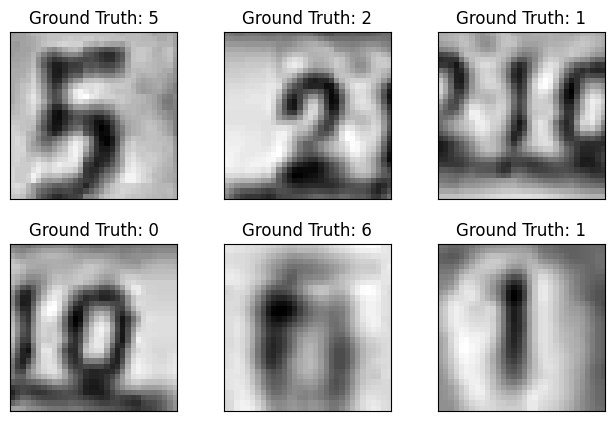

In [29]:
# Iterator über den Test-DataLoader erstellen
examples = enumerate(test_loader)

# Den ersten Batch aus dem Test-DataLoader holen
batch_idx, (example_data, example_targets) = next(examples)

# Neue Figur für die Plots erstellen
fig = plt.figure()

# 6 Bilder aus dem Batch plotten
for i in range(6):
    # Unterteilt die Figur in 2x3 Raster, i+1 = aktuelle Position
    plt.subplot(2, 3, i+1)
    plt.tight_layout()  # Sorgt dafür, dass Plots sich nicht überlappen
    # Zeige das Bild an; example_data[i][0] = 1. Kanal (Graustufe)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    # Titel mit Ground-Truth-Label
    plt.title("Ground Truth: {}".format(example_targets[i]))
    # Achsenbeschriftungen entfernen
    plt.xticks([])
    plt.yticks([])

# Alle geplotteten Bilder anzeigen
plt.show()


## Definition des CNN-Modells

In dieser Zelle wird die Klasse `Net` definiert, die ein Convolutional Neural Network (CNN) implementiert.

- **Zweck:** Definiert die Architektur des neuronalen Netzes für Bilderkennung.
- **Aufbau:**
  1. Convolutional Layer (Feature Extraction)
  2. Max-Pooling (Reduzierung der Dimensionen)
  3. ReLU (Nichtlinearität)
  4. Dropout (Regularisierung)
  5. Flatten (Umwandlung in 1D für Fully Connected Layer)
  6. Fully Connected Layer(s) (klassische Klassifizierung)
  7. Softmax (Wahrscheinlichkeitsausgabe für Klassen)
- **TODO-Liste im Kommentar:** Zeigt, welche Layer du für ein vollständiges CNN einbauen solltest.


In [30]:
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)

# CNN-Klasse definieren
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- Erster Convolutional Layer ---
        # nn.Conv2d: 2D Convolution
        # 3 Input-Kanäle (RGB), 10 Output-Kanäle (Features), Kernelgröße 5x5
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)  # TODO: ggf. auf 1 Input-Kanal anpassen für Graustufen

        # Dropout für die Convolutionen (reduziert Overfitting)
        self.drop = nn.Dropout2d()

        # Fully Connected Layer
        # nn.Linear: verbindet alle Eingangseinheiten mit allen Ausgangseinheiten
        # 1960 Eingangsdimensionen → 1000 Ausgangsdimensionen (muss evtl. an tatsächliche Flatten-Größe angepasst werden)
        self.fc1 = nn.Linear(1960, 1000)

    # --- Forward-Pass ---
    def forward(self, x):
        x = self.conv1(x)               # 1. Convolution
        x = self.drop(x)                # 2. Dropout
        x = F.max_pool2d(x, 2)          # 3. Max-Pooling über 2x2
        x = F.relu(x)                   # 4. ReLU-Aktivierung
        x = x.flatten(1)                # 5. Flattening: CxHxW → 1D für Fully Connected Layer
        x = self.fc1(x)                 # 6. Fully Connected Layer
        x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe
        return x                        # Rückgabe: Log-Wahrscheinlichkeiten pro Klasse

In [31]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

## Initialisierung des Modells, der Gewichte und des Optimizers

In dieser Zelle wird das neuronale Netz erstellt, seine Gewichte initialisiert und der Optimizer definiert.

- `model = Net()`: Erstellt eine Instanz des zuvor definierten CNN-Modells.
- `model.apply(weights_init)`: Wendet eine eigene Initialisierungsfunktion (`weights_init`) auf alle Layer des Modells an.
  Dies sorgt dafür, dass die Anfangsgewichte der Layer sinnvoll gesetzt werden, was das Lernen stabiler und schneller macht.
- `optim.SGD(...)`: Erstellt einen Stochastic Gradient Descent Optimizer.
  - `model.parameters()`: Übergibt die trainierbaren Parameter des Modells.
  - `lr=0.01`: Lernrate.
  - `momentum=0.5`: Verbessert die Konvergenzgeschwindigkeit, indem vorherige Gradienten berücksichtigt werden.


In [32]:
# Erstellt eine Instanz des CNN-Modells (Klasse Net aus vorheriger Zelle)
model = Net()

# Initialisiert die Gewichte aller Layer mit einer benutzerdefinierten Funktion weights_init
# Dadurch starten die Gewichte nicht zufällig schlecht, was Training verbessern kann
model.apply(weights_init)

# Definiert den Optimizer: Stochastic Gradient Descent
# model.parameters(): alle trainierbaren Parameter des Modells
# lr=0.01: Lernrate
# momentum=0.5: hilft, "Schwankungen" im Gradienten auszugleichen
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


## Trainingsroutine

In dieser Zelle wird die Trainingsfunktion `train(epoch)` definiert.
Sie führt einen kompletten Trainingsdurchlauf (Epoch) über den gesamten Trainingsdatensatz aus.

Ablauf:
1. `model.train()`: Schaltet das Modell in den Trainingsmodus (aktiviert z.B. Dropout).
2. Schleife über alle Batches im `train_loader`.
3. `optimizer.zero_grad()`: Setzt Gradienten des vorherigen Backpropagation-Schritts zurück.
4. `output = model(data)`: Modellvorhersage für den aktuellen Batch.
5. `loss = F.nll_loss(...)`: Berechnet die Negative Log-Likelihood Loss (passend für `log_softmax`).
6. `loss.backward()`: Backpropagation – berechnet Gradienten.
7. `optimizer.step()`: Aktualisiert die Modellparameter.
8. Alle 10 Batches wird der aktuelle Trainingsfortschritt (Loss) ausgegeben.


In [33]:
# Haupt-Trainingsroutine
def train(epoch):
    model.train()  # Modell in den Trainingsmodus setzen (Dropout aktiv, BatchNorm aktiviert)

    # Schleife über alle Batches im Training DataLoader
    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()       # Vor jedem Schritt Gradienten zurücksetzen

        output = model(data)        # Modellvorhersage für aktuellen Batch
        loss = F.nll_loss(output, target)  # Loss berechnen (für log_softmax geeignet)

        loss.backward()             # Backpropagation: Gradienten berechnen
        optimizer.step()            # Parameter-Update mittels Optimizer

        # Fortschrittsanzeige alle 10 Batches
        if batch_idx % 10 == 0:
            print(
                'Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                    epoch,                          # Aktuelle Epoche
                    batch_idx * len(data),          # Anzahl verarbeiteter Trainingsbeispiele
                    len(train_loader.dataset),      # Gesamtzahl der Trainingsdaten
                    loss.item()                     # Aktueller Loss-Wert
                )
            )


## Test-/Evaluierungsroutine

In dieser Zelle wird die Funktion `test()` definiert, die das Modell auf den Testdaten auswertet.

Ablauf:
1. `model.eval()`: Setzt das Modell in den Evaluierungsmodus
   (Dropout deaktiviert, BatchNorm verwendet Durchschnittswerte).
2. `torch.no_grad()`: Deaktiviert Gradientenberechnung – spart Zeit und Speicher.
3. Schleife über `test_loader`:
   - Modellvorhersagen berechnen
   - Loss aufsummieren (für Durchschnitt am Ende)
   - Vorhersagen mit den Zielwerten vergleichen → Accuracy
4. Nach der Schleife:
   - Durchschnitts-Loss berechnen
   - Genauigkeit berechnen und ausgeben


In [34]:
# Testfunktion, um das Modell auf den Testdaten auszuwerten
def test():
    model.eval()      # Modell in den Evaluierungsmodus setzen (Dropout aus)
    test_loss = 0     # Summe der Loss-Werte
    correct = 0       # Anzahl korrekter Vorhersagen

    # Im Testmodus keine Gradienten berechnen → schneller und spart Speicher
    with torch.no_grad():
        # Schleife über alle Test-Batches
        for data, target in test_loader:

            output = model(data)  # Modellvorhersage

            # Addiere den Loss des Batches (size_average=False = Summe statt Mittelwert)
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Wähle die Klasse mit der höchsten Wahrscheinlichkeit
            pred = output.data.max(1, keepdim=True)[1]

            # Vergleiche Vorhersagen mit dem Ground-Truth
            correct += pred.eq(target.data.view_as(pred)).sum()

    # Durchschnittlichen Loss berechnen
    test_loss /= len(test_loader.dataset)

    # Ergebnisse ausgeben
    print(
        '\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )

## Ausführen des Trainings und Testens über mehrere Epochen

In dieser Zelle wird zuerst die Anfangsleistung des Modells auf den Testdaten berechnet („untrainiertes Modell“).
Anschließend wird das Modell über mehrere Epochen trainiert. Nach jeder Epoche wird erneut getestet, um den Fortschritt zu messen.

Ablauf:
1. `test()`: Bewertung des Modells vor dem Training (Baseline).
2. `n_epochs = 3`: Anzahl der Trainingsdurchläufe (Epochen).
3. Schleife über alle Epochen:
   - `train(epoch)`: Trainingsdurchlauf über alle Trainingsdaten.
   - `test()`: Bewertung der Modellleistung nach dieser Epoche.


In [35]:
# Anfangsleistung des Modells testen (ungelerntes Modell)
test()

# Anzahl der Trainings-Epochen festlegen
n_epochs = 3

# Trainings-/Testschleife über mehrere Epochen
for epoch in range(1, n_epochs + 1):
    train(epoch)  # Modell trainieren
    test()        # Modell nach der Epoche testen


/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_6949/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe



Test set: Avg. loss: 6.9468, Accuracy: 0/26032 (0%)

Train Epoch: 1 [0/73257]	Loss: 7.007236
Train Epoch: 1 [640/73257]	Loss: 4.245095
Train Epoch: 1 [1280/73257]	Loss: 3.135654
Train Epoch: 1 [1920/73257]	Loss: 2.969677
Train Epoch: 1 [2560/73257]	Loss: 3.092448
Train Epoch: 1 [3200/73257]	Loss: 2.768130
Train Epoch: 1 [3840/73257]	Loss: 2.831016
Train Epoch: 1 [4480/73257]	Loss: 2.759414
Train Epoch: 1 [5120/73257]	Loss: 2.796334
Train Epoch: 1 [5760/73257]	Loss: 3.036316
Train Epoch: 1 [6400/73257]	Loss: 2.880719
Train Epoch: 1 [7040/73257]	Loss: 2.699786
Train Epoch: 1 [7680/73257]	Loss: 2.901366
Train Epoch: 1 [8320/73257]	Loss: 2.979138
Train Epoch: 1 [8960/73257]	Loss: 2.874054
Train Epoch: 1 [9600/73257]	Loss: 3.245134
Train Epoch: 1 [10240/73257]	Loss: 2.845555
Train Epoch: 1 [10880/73257]	Loss: 2.744415
Train Epoch: 1 [11520/73257]	Loss: 2.592861
Train Epoch: 1 [12160/73257]	Loss: 2.936898
Train Epoch: 1 [12800/73257]	Loss: 2.526252
Train Epoch: 1 [13440/73257]	Loss: 2.64475

## Vorhersagen des trainierten Modells visualisieren

In dieser Zelle wird das Modell auf einige zuvor geladene Beispielbilder angewendet.
Die Predictions (Vorhersagen) werden zusammen mit den Bildern dargestellt.

Ablauf:
1. `output = model(example_data)`: Modell erzeugt Vorhersagen für die ausgewählten Testbilder.
2. `plt.figure()`: Neue Plot-Figur.
3. Schleife über mehrere Bilder:
   - Bild anzeigen (`imshow`)
   - Modellvorhersage ermitteln (`output.data.max(...)`)
   - Prediction als Titel ausgeben
   - Achsen entfernen
4. `plt.show()`: Darstellung der Ergebnisse.


/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_6949/3378217945.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


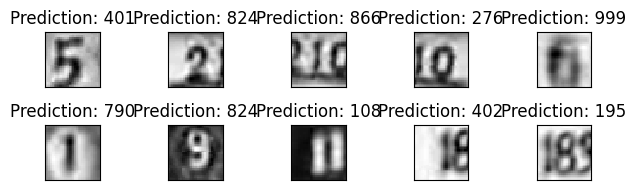

In [15]:
# Modellvorhersagen für die zuvor geladenen Beispielbilder berechnen
output = model(example_data)

# Neue Figur für die Plots erstellen
fig = plt.figure()

# Zeige die ersten 10 Bilder und ihre Vorhersagen
for i in range(10):
    plt.subplot(5, 5, i+1)  # 5x5 Raster, aktueller Plot: i+1
    plt.tight_layout()      # Überlappungen vermeiden

    # Beispielbild anzeigen (Graustufe)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')

    # Vorhersage ermitteln:
    # max(1) → höchste Wahrscheinlichkeit entlang der Klassenachse
    # [1] → Index des Maximums → vorhergesagte Klasse
    predicted_label = output.data.max(1, keepdim=True)[1][i].item()

    # Titel mit der Vorhersage
    plt.title("Prediction: {}".format(predicted_label))

    # Achsen entfernen
    plt.xticks([])
    plt.yticks([])

# Plots anzeigen
plt.show()


## Chat GPT Ergänzungen

### Flexible CNN-Architektur für SVHN

Diese Zelle definiert ein flexibles Convolutional Neural Network (CNN) für das SVHN-Datenset.

Besonderheiten:
- Anzahl der Convolutional Layers kann gewählt werden (`num_conv_layers=1 oder 2`)
- Konfigurierbare Dropout-Rate (`dropout_rate`)
- Größe des Fully Connected Hidden Layers ist einstellbar (`fc_hidden`)
- Automatische Berechnung der richtigen Flatten-Dimension abhängig von Netzwerkarchitektur
- Die Architektur besteht aus:
  1. Convolution + ReLU + MaxPool
  2. Optional: zweite Convolution + Dropout + ReLU + MaxPool
  3. Flatten
  4. Fully Connected Layer
  5. Output-Layer mit 10 Klassen
  6. `log_softmax` für NLLLoss-kompatible Wahrscheinlichkeitsverteilung


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SVHNCNN(nn.Module):
    def __init__(
        self,
        num_conv_layers=2,   # Anzahl der Convolutional Layer (1 oder 2)
        dropout_rate=0.3,    # Dropout-Wahrscheinlichkeit
        fc_hidden=50         # Anzahl der Neuronen im Fully Connected Hidden Layer
    ):
        super().__init__()

        self.num_conv_layers = num_conv_layers

        # --- 1. Convolution Layer ---
        # Eingabe: 3 Kanäle (RGB), Ausgabe: 10 Feature Maps, Kernel 5x5
        # Bildgröße: 32x32 -> 28x28
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)

        # --- 2. Convolution Layer (optional) ---
        # Eingabe: 10 Feature Maps, Ausgabe: 20 Feature Maps
        # Bildgröße nach Conv2: 14x14 -> 10x10
        if num_conv_layers >= 2:
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        else:
            self.conv2 = None

        # --- Dropout Layer ---
        # Dropout für Convolution Outputs (Spatial Dropout)
        self.dropout = nn.Dropout2d(p=dropout_rate)

        # ============================================
        # AUTOMATISCHE BERECHNUNG DER FC-EINGANGSGRÖSSE
        # ============================================

        # Wenn nur eine Conv-Schicht:
        # conv1: 32 → 28 → MaxPool → 14
        # Feature Maps: 10
        if num_conv_layers == 1:
            conv_output_dim = 10 * 14 * 14

        # Wenn zwei Conv-Schichten:
        # conv1: 32 → 28 → pool → 14
        # conv2: 14 → 10 → pool → 5
        # Feature Maps: 20
        else:
            conv_output_dim = 20 * 5 * 5

        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(conv_output_dim, fc_hidden)
        self.fc2 = nn.Linear(fc_hidden, 10)  # 10 Klassen (Ziffern 0–9)

    def forward(self, x):

        # --- Block 1 ---
        x = F.relu(self.conv1(x))     # Convolution + ReLU
        x = F.max_pool2d(x, 2)        # MaxPooling 2x2

        # --- Optionaler Block 2 ---
        if self.conv2 is not None:
            x = F.relu(self.dropout(self.conv2(x)))  # Conv2 → Dropout → ReLU
            x = F.max_pool2d(x, 2)                   # Pooling 2x2

        # --- Flatten der Feature Maps ---
        x = x.view(x.size(0), -1)

        # --- Fully Connected Layers ---
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # --- Output: Log-Softmax für NLLLoss ---
        return F.log_softmax(x, dim=1)


### Experiment 1: Netzwerktiefe

In [19]:
model_A = SVHNCNN(num_conv_layers=1)
model_B = SVHNCNN(num_conv_layers=2)


### Experiment 2: learning rates

In [20]:
for lr in [0.1, 0.01, 0.001]:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)


### Experiment 3: SGD vs. ADAM

In [21]:
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=0.001)


### Experiment 4: verschiedene Batch-Sizes

In [22]:
for bs in [32, 64, 128]:
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)


## Training, Test und Output

### Experimente: Einfluss von Netzwerktiefe, Learning Rate, Optimizer und Batch Size

In dieser Zelle werden vier systematische Experimente durchgeführt, um den Einfluss verschiedener Hyperparameter auf ein CNN für SVHN zu analysieren:

1. **Netzwerktiefe**
   Vergleich zwischen 1 und 2 Convolutional Layers.

2. **Learning Rate**
   Vergleich der Lernraten: 0.1, 0.01, 0.001.

3. **Optimizer**
   Vergleich zwischen klassischem SGD und Adam.

4. **Batch Size**
   Training mit Batchgrößen: 32, 64, 128.

Alle Trainings- und Testergebnisse werden gespeichert und am Ende zusammen in einem Accuracy-Plot dargestellt.


=== Experiment 1: Netzwerktiefe ===
Epoch 1 | Test Acc: 23.64% | Test Loss: 2.1441
Epoch 2 | Test Acc: 56.85% | Test Loss: 1.3966
Epoch 3 | Test Acc: 70.91% | Test Loss: 0.9845
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2172
Epoch 2 | Test Acc: 21.14% | Test Loss: 2.1673
Epoch 3 | Test Acc: 62.30% | Test Loss: 1.2708

=== Experiment 2: Learning Rate ===
Epoch 1 | Test Acc: 79.66% | Test Loss: 0.7160
Epoch 2 | Test Acc: 85.37% | Test Loss: 0.5256
Epoch 3 | Test Acc: 87.09% | Test Loss: 0.4638
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2162
Epoch 2 | Test Acc: 30.60% | Test Loss: 2.0473
Epoch 3 | Test Acc: 69.95% | Test Loss: 1.0494
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2656
Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2373
Epoch 3 | Test Acc: 19.59% | Test Loss: 2.2301

=== Experiment 3: Optimizer ===
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2235
Epoch 2 | Test Acc: 19.90% | Test Loss: 2.1938
Epoch 3 | Test Acc: 59.01% | Test Loss: 1.2962
Epoch 1 | Test Acc: 82.16% | Test Loss: 0.6524
E

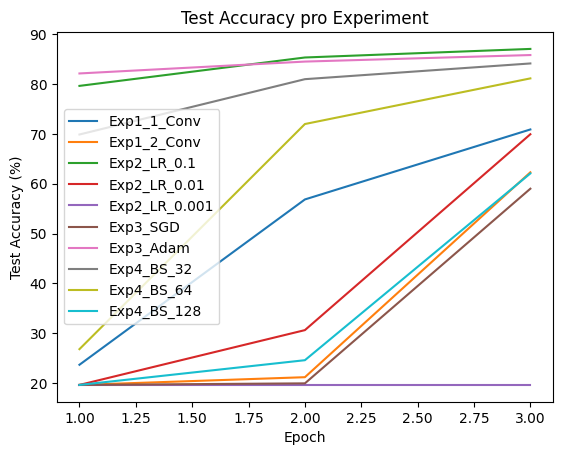

In [23]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- Experiment Setup ---
n_epochs = 3  # für schnelle Tests, später erhöhen
train_batch_sizes = [64]  # Basiswert, außer Experiment 4
test_batch_size = 1000

# Dictionary zum Speichern aller Ergebnisse
all_results = {}

# --- Hilfsfunktion: Training + Testen ---
def run_training(model, optimizer, train_loader, test_loader, n_epochs=3):
    """
    Führt Training + Testen über mehrere Epochen durch.
    Gibt Listen von Training Loss, Test Loss und Accuracy zurück.
    """
    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(1, n_epochs + 1):

        # ===== Training =====
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        # ===== Testen =====
        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                # Summe über alle Samples (wie im Original-MNIST-Beispiel)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)           # Klassen mit höchster Wahrscheinlichkeit
                correct += pred.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch} | Test Acc: {accuracy:.2f}% | Test Loss: {test_loss:.4f}")

    return train_losses, test_losses, test_accuracies


# ============================================================
# EXPERIMENT 1 — Einfluss der Netzwerktiefe
# ============================================================
print("=== Experiment 1: Netzwerktiefe ===")

models = {
    "1_Conv": SVHNCNN(num_conv_layers=1),
    "2_Conv": SVHNCNN(num_conv_layers=2)
}

for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp1_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }


# ============================================================
# EXPERIMENT 2 — Learning Rate Vergleich
# ============================================================
print("\n=== Experiment 2: Learning Rate ===")

lrs = [0.1, 0.01, 0.001]

for lr in lrs:
    model = SVHNCNN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp2_LR_{lr}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }


# ============================================================
# EXPERIMENT 3 — Optimizer Vergleich
# ============================================================
print("\n=== Experiment 3: Optimizer ===")

optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam
}

for name, opt_class in optimizers.items():
    model = SVHNCNN(num_conv_layers=2)

    # typische Default-Learning-Rates
    if name == "SGD":
        optimizer = opt_class(model.parameters(), lr=0.01, momentum=0.5)
    else:
        optimizer = opt_class(model.parameters(), lr=0.001)

    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp3_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }


# ============================================================
# EXPERIMENT 4 — Batch Size Vergleich
# ============================================================
print("\n=== Experiment 4: Batch Size ===")

batch_sizes = [32, 64, 128]

for bs in batch_sizes:
    train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    model = SVHNCNN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    train_losses, test_losses, accuracies = run_training(
        model, optimizer, train_loader_exp, test_loader, n_epochs
    )

    all_results[f"Exp4_BS_{bs}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }


# ============================================================
# PLOT ALLER EXPERIMENT-ERGEBNISSE
# ============================================================

for key, res in all_results.items():
    plt.plot(range(1, n_epochs+1), res["accuracy"], label=key)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy pro Experiment")
plt.legend()
plt.show()


#### jetzt mit anderer Epochenzahl

=== Experiment 1: Netzwerktiefe ===
Epoch 1 | Test Acc: 23.39% | Test Loss: 2.1477
Epoch 2 | Test Acc: 50.87% | Test Loss: 1.5619
Epoch 3 | Test Acc: 69.91% | Test Loss: 1.0033
Epoch 4 | Test Acc: 72.75% | Test Loss: 0.9187
Epoch 5 | Test Acc: 77.75% | Test Loss: 0.7686
Epoch 6 | Test Acc: 79.57% | Test Loss: 0.7213
Epoch 7 | Test Acc: 80.26% | Test Loss: 0.6998
Epoch 8 | Test Acc: 81.39% | Test Loss: 0.6689
Epoch 9 | Test Acc: 81.91% | Test Loss: 0.6475
Epoch 10 | Test Acc: 81.48% | Test Loss: 0.6712
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2160
Epoch 2 | Test Acc: 33.95% | Test Loss: 1.9596
Epoch 3 | Test Acc: 75.93% | Test Loss: 0.8703
Epoch 4 | Test Acc: 80.79% | Test Loss: 0.7015
Epoch 5 | Test Acc: 82.39% | Test Loss: 0.6542
Epoch 6 | Test Acc: 82.83% | Test Loss: 0.6230
Epoch 7 | Test Acc: 83.68% | Test Loss: 0.6036
Epoch 8 | Test Acc: 84.42% | Test Loss: 0.5784
Epoch 9 | Test Acc: 84.74% | Test Loss: 0.5629
Epoch 10 | Test Acc: 84.78% | Test Loss: 0.5547

=== Experiment 2: Lea

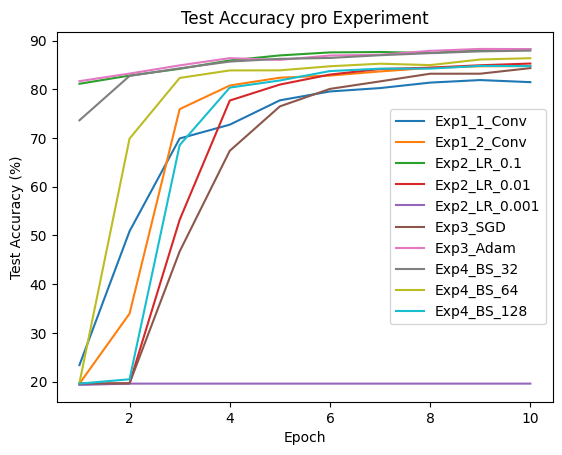

In [24]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- Experiment Setup ---
n_epochs = 10  # für schnelle Tests, später erhöhen
train_batch_sizes = [64]  # Basiswert, außer Experiment 4
test_batch_size = 1000

# Dictionary zum Speichern aller Ergebnisse
all_results = {}

# --- Hilfsfunktion zum Training und Testen ---
def run_training(model, optimizer, train_loader, test_loader, n_epochs=3):
    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(1, n_epochs + 1):
        # Training
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        # Test
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch} | Test Acc: {accuracy:.2f}% | Test Loss: {test_loss:.4f}")

    return train_losses, test_losses, test_accuracies

# --- Experiment 1: Einfluss der Netzwerktiefe ---
print("=== Experiment 1: Netzwerktiefe ===")
models = {
    "1_Conv": SVHNCNN(num_conv_layers=1),
    "2_Conv": SVHNCNN(num_conv_layers=2)
}
for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp1_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Experiment 2: Learning Rate ---
print("\n=== Experiment 2: Learning Rate ===")
lrs = [0.1, 0.01, 0.001]
for lr in lrs:
    model = SVHNCNN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp2_LR_{lr}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Experiment 3: Optimizer Vergleich ---
print("\n=== Experiment 3: Optimizer ===")
optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam
}
for name, opt_class in optimizers.items():
    model = SVHNCNN(num_conv_layers=2)
    if name == "SGD":
        optimizer = opt_class(model.parameters(), lr=0.01, momentum=0.5)
    else:
        optimizer = opt_class(model.parameters(), lr=0.001)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp3_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Experiment 4: Batch Size ---
print("\n=== Experiment 4: Batch Size ===")
batch_sizes = [32, 64, 128]
for bs in batch_sizes:
    train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    model = SVHNCNN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader_exp, test_loader, n_epochs)
    all_results[f"Exp4_BS_{bs}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Plots: Accuracy pro Experiment ---
for key, res in all_results.items():
    plt.plot(range(1, n_epochs+1), res["accuracy"], label=key)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy pro Experiment")
plt.legend()
plt.show()
